    y     N  X  S  M         Q          H     V  P         Z    p_true  \
0  90   767  1  0  6 -1.129308  48.895660   767  0  0.003611  0.142422   
1  57  1307  0  2  9 -0.642893  53.950571  1307  0 -1.019354  0.033164   
2  13  1016  1  1  9  1.194699  52.435899  1016  0 -1.140133  0.011976   
3  21  1010  0  0  1  1.235346  48.332529  1010  1  0.072223  0.017037   
4  11  1135  0  2  2 -0.480934  55.450660  1135  0 -1.022091  0.009386   

     prob_X  
0  0.071634  
1  0.678135  
2  0.799441  
3  0.130300  
4  0.481416  
=== 単純な差による推定（Naive Difference）===
X=1（新温度制御あり）の平均不良率: 0.0370
X=0（新温度制御なし）の平均不良率: 0.1340
単純な差 (mean_1 - mean_0): -0.0970
95%信頼区間: [-0.1099, -0.0841]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_X, beta_S, beta_M, beta_Q, beta_H, beta_V, beta_P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -2.489  0.007  -2.502   -2.474        0.0      0.0    4556.0   
beta_X    -0.144  0.011  -0.164   -0.125        0.0      0.0    7082.0   
beta_S    -1.024  0.005  -1.033   -1.014        0.0      0.0    7887.0   
beta_M     0.629  0.004   0.622    0.636        0.0      0.0    7786.0   
beta_Q    -0.893  0.004  -0.900   -0.886        0.0      0.0    6747.0   
beta_H     0.489  0.003   0.483    0.495        0.0      0.0    7897.0   
beta_V     0.020  0.003   0.013    0.026        0.0      0.0    7455.0   
beta_P     0.957  0.007   0.943    0.970        0.0      0.0    5325.0   

           ess_tail  r_hat  
intercept    5176.0    1.0  
beta_X       6363.0    1.0  
beta_S       6020.0    1.0  
beta_M       5830.0    1.0  
beta_Q       6153.0    1.0  
beta_H       5815.0    1.0  
beta_V       5970.0    1.0  
beta_P       5114.0    1.0  

推定された平均因果効果 (ATE: 不良率の差, X=1 - X=0)
平均: -0.0103
95%信用区間: [-0.0118, -0.0

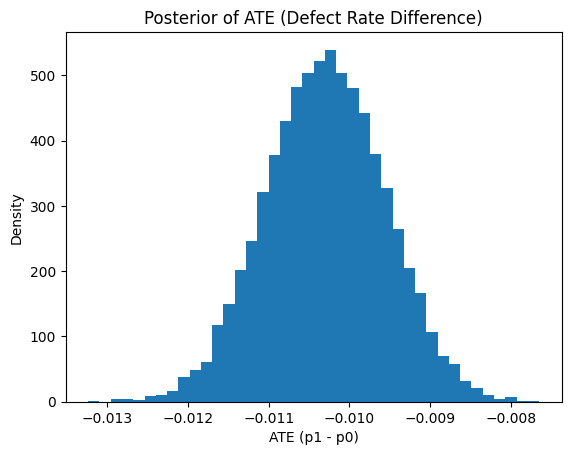

In [ ]:
# ============================================
#  6-1 製造現場プロセス改善
# ============================================

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

RANDOM_SEED = 1
rng = np.random.default_rng(RANDOM_SEED)

# -----------------------------
# 1. シミュレーション用データ生成
# -----------------------------

def simulate_manufacturing_data(n=500, rng=None):
    """
    製造現場のシナリオに沿った疑似データを生成する関数。
    n : ロット数
    戻り値 : pandas.DataFrame
    """
    if rng is None:
        rng = np.random.default_rng()

    # --- 共変量の生成 ---

    # オペレータ熟練度 S (0=新人,1=中堅,2=ベテラン)
    S = rng.integers(0, 3, size=n)

    # 炉の経年 M (1〜10年)
    M = rng.integers(1, 11, size=n)

    # 部品ロット品質 Q (平均0,分散1) -> 値が低いほど品質悪いとする
    Q = rng.normal(loc=0.0, scale=1.0, size=n)

    # 湿度 H (40〜70%くらい)
    H = rng.normal(loc=55.0, scale=7.0, size=n)

    # ロット数量 V (500〜2000個程度)
    V = rng.integers(500, 2001, size=n)

    # 製品種別 P (0=易しい製品,1=難しい製品)
    P = rng.integers(0, 2, size=n)

    # --- 施策割当 (新温度制御導入 X) の生成 ---
    # ロジスティックモデル:
    # logit(Pr(X=1)) = α0 + αS*S + αM*M + αQ*Q + αP*P
    # S: ベテランラインから導入しやすい (+)
    # M: 古い炉から導入しやすい (+)
    # Q: 品質の悪いロットには慎重で導入しにくい (-)
    # P: 難しい製品にはまだ様子見で導入しにくい (-)

    alpha0 = -1.0
    alpha_S = 0.4
    alpha_M = 0.15
    alpha_Q = -0.5
    alpha_P = -0.7

    lin_X = (alpha0
             + alpha_S * S
             + alpha_M * (M - M.mean()) / M.std()
             + alpha_Q * Q
             + alpha_P * P)
    prob_X = 1 / (1 + np.exp(-lin_X))
    X = rng.binomial(1, prob_X, size=n)

    # --- メディエータ Z (プロセス安定度: 温度バラつき) の生成 ---
    # Z は「悪いほど大きい」指標とする（温度プロファイル標準偏差など）
    # Z = β0 + βX*X + βS*S + βM*M + βH*H + βP*P + ε
    # X=1 で Z が小さくなるように βX<0 に設定
    beta0 = 0.0
    beta_X = -0.6   # 新制御でバラつき減
    beta_S = -0.2   # 熟練者のほうが安定
    beta_M = 0.15   # 古い炉ほど不安定
    beta_H = 0.05   # 湿度が高いと不安定
    beta_P = 0.4    # 難しい製品は不安定

    # 標準化してから線形結合
    M_std = (M - M.mean()) / M.std()
    H_std = (H - H.mean()) / H.std()

    lin_Z = (beta0
             + beta_X * X
             + beta_S * S
             + beta_M * M_std
             + beta_H * H_std
             + beta_P * P)
    Z = lin_Z + rng.normal(0, 0.7, size=n)  # ノイズを追加

    # --- アウトカム Y (不良数) の生成 ---
    # 各ロットの不良率 p をロジスティックモデルで生成
    # logit(p) = γ0 + γX*X + γS*S + γM*M + γQ*Q + γH*H + γV*V + γP*P + γZ*Z
    # ここでは真の生成過程では Z も使う（プロセス安定度を通じた影響を持たせる）
    gamma0 = -3.0
    gamma_X = -0.5   # 新制御で不良率低下
    gamma_S = -0.2   # 熟練者ほど不良率低い
    gamma_M = 0.2    # 古い炉ほど不良率高い
    gamma_Q = -0.4   # Q が大きい（良い）ほど不良率低い
    gamma_H = 0.3    # 湿度が高いと不良率高い
    gamma_V = 0.0    # ロットサイズの効果は今回は0にしておく
    gamma_P = 0.6    # 難しい製品は不良率高い
    gamma_Z = 0.7    # バラつきが大きいほど不良率高い

    # 標準化
    H_std = (H - H.mean()) / H.std()
    V_std = (V - V.mean()) / V.std()

    lin_p = (gamma0
             + gamma_X * X
             + gamma_S * S
             + gamma_M * M_std
             + gamma_Q * Q
             + gamma_H * H_std
             + gamma_V * V_std
             + gamma_P * P
             + gamma_Z * Z)
    p = 1 / (1 + np.exp(-lin_p))

    # ロットごとの不良数を Binomial で生成
    y = rng.binomial(V, p)

    df = pd.DataFrame({
        "y": y,
        "N": V,
        "X": X,
        "S": S,
        "M": M,
        "Q": Q,
        "H": H,
        "V": V,
        "P": P,
        "Z": Z,
        "p_true": p,
        "prob_X": prob_X,
    })

    return df

# -----------------------------
# 単純な差（naive difference）の計算
# -----------------------------

def estimate_naive_difference(df):
    """
    新温度制御あり (X=1) と なし (X=0) の
    平均不良率の単純な差を計算する。

    戻り値:
      diff      : 平均不良率の差 (mean_1 - mean_0)
      mean_1    : X=1 の平均不良率
      mean_0    : X=0 の平均不良率
      ci_low    : 95%信頼区間の下限
      ci_high   : 95%信頼区間の上限
    """
    df = df.copy()
    df["rate"] = df["y"] / df["N"]

    # グループ別の平均・分散・サンプル数
    grp = df.groupby("X")["rate"]
    mean_0 = grp.mean().loc[0]
    mean_1 = grp.mean().loc[1]
    var_0 = grp.var(ddof=1).loc[0]
    var_1 = grp.var(ddof=1).loc[1]
    n_0 = grp.size().loc[0]
    n_1 = grp.size().loc[1]

    diff = mean_1 - mean_0

    # 独立な2群の差の標準誤差（Welchの近似）
    se = np.sqrt(var_1 / n_1 + var_0 / n_0)

    # 95%信頼区間（標準正規近似）
    z = 1.96
    ci_low = diff - z * se
    ci_high = diff + z * se

    return diff, mean_1, mean_0, ci_low, ci_high

# -----------------------------
# 2. ベイズロジスティック回帰モデル
#    (交絡因子調整付きで X の効果を推定)
# -----------------------------

def fit_bayesian_causal_logistic(df, draws=2000, tune=1000, random_seed=RANDOM_SEED):
    """
    y ~ Binomial(N, p)
    logit(p) = γ0 + γX*X + γS*S + γM*M + γQ*Q + γH*H + γV*V + γP*P

    というモデルを pymc で推定し、トレースとデータを返す。
    """
    # 共変量を少し整形（標準化等）
    X = df["X"].values
    S = df["S"].values
    M = df["M"].values
    Q = df["Q"].values
    H = df["H"].values
    V = df["V"].values
    P = df["P"].values

    y = df["y"].values
    N = df["N"].values

    M_std = (M - M.mean()) / M.std()
    H_std = (H - H.mean()) / H.std()
    V_std = (V - V.mean()) / V.std()

    with pm.Model() as model:
        # 事前分布
        intercept = pm.Normal("intercept", mu=0.0, sigma=5.0)

        beta_X = pm.Normal("beta_X", mu=0.0, sigma=5.0)

        beta_S = pm.Normal("beta_S", mu=0.0, sigma=5.0)
        beta_M = pm.Normal("beta_M", mu=0.0, sigma=5.0)
        beta_Q = pm.Normal("beta_Q", mu=0.0, sigma=5.0)
        beta_H = pm.Normal("beta_H", mu=0.0, sigma=5.0)
        beta_V = pm.Normal("beta_V", mu=0.0, sigma=5.0)
        beta_P = pm.Normal("beta_P", mu=0.0, sigma=5.0)

        # 線形予測子
        eta = (intercept
               + beta_X * X
               + beta_S * S
               + beta_M * M_std
               + beta_Q * Q
               + beta_H * H_std
               + beta_V * V_std
               + beta_P * P)

        p = pm.math.sigmoid(eta)

        # 尤度（Binomial）
        y_obs = pm.Binomial("y_obs", n=N, p=p, observed=y)

        # サンプリング
        trace = pm.sample(
            draws=draws,
            tune=tune,
            target_accept=0.9,
            random_seed=random_seed,
            chains=4
        )

    return model, trace


# -----------------------------
# 3. ACE の計算
# -----------------------------

def compute_ace_from_trace(df, trace):
    """
    事後サンプルから do(X=1), do(X=0) の購買確率を計算し、
    ACE（不良率の差）を推定する。
    """
    X = df["X"].values
    S = df["S"].values
    M = df["M"].values
    Q = df["Q"].values
    H = df["H"].values
    V = df["V"].values
    P = df["P"].values
    N = df["N"].values

    M_std = (M - M.mean()) / M.std()
    H_std = (H - H.mean()) / H.std()
    V_std = (V - V.mean()) / V.std()

    # 事後サンプルを取り出す
    post = trace.posterior  # xarray
    intercept = post["intercept"].values  # shape: (chain, draw)
    beta_X = post["beta_X"].values
    beta_S = post["beta_S"].values
    beta_M = post["beta_M"].values
    beta_Q = post["beta_Q"].values
    beta_H = post["beta_H"].values
    beta_V = post["beta_V"].values
    beta_P = post["beta_P"].values

    # chain と draw をまとめてサンプル次元にする
    n_chain, n_draw = intercept.shape
    n_samples = n_chain * n_draw

    intercept = intercept.reshape(n_samples, 1)  # (S, 1)
    beta_X = beta_X.reshape(n_samples, 1)
    beta_S = beta_S.reshape(n_samples, 1)
    beta_M = beta_M.reshape(n_samples, 1)
    beta_Q = beta_Q.reshape(n_samples, 1)
    beta_H = beta_H.reshape(n_samples, 1)
    beta_V = beta_V.reshape(n_samples, 1)
    beta_P = beta_P.reshape(n_samples, 1)

    # 観測データは (n,) なので (1, n) にしてブロードキャスト
    S_row = S.reshape(1, -1)
    M_std_row = M_std.reshape(1, -1)
    Q_row = Q.reshape(1, -1)
    H_std_row = H_std.reshape(1, -1)
    V_std_row = V_std.reshape(1, -1)
    P_row = P.reshape(1, -1)

    # do(X=1) の世界
    X1_row = np.ones_like(S_row)
    eta1 = (intercept
            + beta_X * X1_row
            + beta_S * S_row
            + beta_M * M_std_row
            + beta_Q * Q_row
            + beta_H * H_std_row
            + beta_V * V_std_row
            + beta_P * P_row)
    p1 = 1 / (1 + np.exp(-eta1))  # shape: (samples, n)

    # do(X=0) の世界
    X0_row = np.zeros_like(S_row)
    eta0 = (intercept
            + beta_X * X0_row
            + beta_S * S_row
            + beta_M * M_std_row
            + beta_Q * Q_row
            + beta_H * H_std_row
            + beta_V * V_std_row
            + beta_P * P_row)
    p0 = 1 / (1 + np.exp(-eta0))

    # 各サンプルでの ATE（不良率の平均差）
    # ATE = E[p(Y=1 | do(X=1)) - p(Y=1 | do(X=0))]
    ate_samples = (p1 - p0).mean(axis=1)  # (samples,)

    return ate_samples

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

def simulate_manufacturing_data(n=500, rng=None):
    """
    製造データ生成関数。
    - 良いライン(熟練Sが高い、部品品質Qが高い)ほど新制御X=1を導入しやすい
    - 同じS,Qがもともとの不良率にも強く効く
    - 新制御の真の効果はほぼゼロ（γ_X ≈ 0）
      → 単純比較は「大きな効果があるように見える」が、
         交絡を調整すると効果は小さい／ほぼゼロになることを狙った設定
    """
    if rng is None:
        rng = np.random.default_rng()

    # --- 共変量の生成 ---

    # オペレータ熟練度 S (0=新人,1=中堅,2=ベテラン)
    S = rng.integers(0, 3, size=n)

    # 炉の経年 M (1〜10年)
    M = rng.integers(1, 11, size=n)

    # 部品ロット品質 Q (平均0,分散1) -> 値が大きいほど品質良い
    Q = rng.normal(loc=0.0, scale=1.0, size=n)

    # 湿度 H (40〜70%くらい)
    H = rng.normal(loc=55.0, scale=7.0, size=n)

    # ロット数量 V (500〜2000個程度)
    V = rng.integers(500, 2001, size=n)

    # 製品種別 P (0=易しい製品,1=難しい製品)
    P = rng.integers(0, 2, size=n)

    # 標準化
    M_std = (M - M.mean()) / M.std()
    H_std = (H - H.mean()) / H.std()

    # --- 施策割当 X（新温度制御）の生成 ---
    # 良いラインに偏って導入されるようにパラメータを強く設定
    # logit(Pr(X=1)) = α0 + αS*S + αQ*Q + αM*M + αP*P
    alpha0 = -1.5
    alpha_S = 1.2   # 熟練者ほど導入されやすい（強め）
    alpha_Q = 1.0   # 品質の良い部品ほど導入されやすい（強め）
    alpha_M = 0.4   # 古い炉から導入されやすい
    alpha_P = -1.0  # 難しい製品にはまだ様子見（導入されにくい）

    lin_X = (alpha0
             + alpha_S * S
             + alpha_Q * Q
             + alpha_M * M_std
             + alpha_P * P)
    prob_X = 1 / (1 + np.exp(-lin_X))
    X = rng.binomial(1, prob_X, size=n)

    # --- メディエータ Z（プロセス安定度）の生成 ---
    # Z: 温度バラつき（悪いほど大きい）
    beta0 = 0.0
    beta_X = -0.3   # 新制御の安定度への効果はやや小さめ
    beta_S = -0.5   # 熟練者はかなり安定
    beta_M = 0.3    # 古い炉は不安定
    beta_H = 0.2    # 湿度が高いと不安定
    beta_P = 0.5    # 難しい製品は不安定

    lin_Z = (beta0
             + beta_X * X
             + beta_S * S
             + beta_M * M_std
             + beta_H * H_std
             + beta_P * P)
    Z = lin_Z + rng.normal(0, 0.7, size=n)

    # --- アウトカム Y（不良数）の生成 ---
    # 真の新制御の効果はほぼゼロに設定する
    # logit(p) = γ0 + γX*X + γS*S + γQ*Q + γM*M + γH*H + γP*P + γZ*Z
    gamma0 = -2.5
    gamma_X = -0.05   # ほぼゼロ（真の改善効果は小さい）
    gamma_S = -0.8    # 熟練者ほど不良率かなり低い
    gamma_Q = -0.9    # 品質の良い部品ほど不良率かなり低い
    gamma_M = 0.5     # 古い炉ほど不良率高い
    gamma_H = 0.4     # 湿度が高いと不良率高い
    gamma_P = 0.7     # 難しい製品は不良率高い
    gamma_Z = 0.4     # バラつきが大きいと不良率高い

    H_std = (H - H.mean()) / H.std()
    V_std = (V - V.mean()) / V.std()  # 今回は使わないが一応計算

    lin_p = (gamma0
             + gamma_X * X
             + gamma_S * S
             + gamma_Q * Q
             + gamma_M * M_std
             + gamma_H * H_std
             + gamma_P * P
             + gamma_Z * Z)

    p = 1 / (1 + np.exp(-lin_p))

    # 不良数 y ~ Binomial(N, p)
    y = rng.binomial(V, p)

    df = pd.DataFrame({
        "y": y,
        "N": V,
        "X": X,
        "S": S,
        "M": M,
        "Q": Q,
        "H": H,
        "V": V,
        "P": P,
        "Z": Z,
        "p_true": p,
        "prob_X": prob_X,
    })

    return df

# -----------------------------
# 4. 実行例
# -----------------------------

if __name__ == "__main__":
    # 1) データ生成
    df = simulate_manufacturing_data(n=1000, rng=rng)
    print(df.head())

    # 単純な差による推定
    diff, mean_1, mean_0, ci_low, ci_high = estimate_naive_difference(df)

    print("=== 単純な差による推定（Naive Difference）===")
    print(f"X=1（新温度制御あり）の平均不良率: {mean_1:.4f}")
    print(f"X=0（新温度制御なし）の平均不良率: {mean_0:.4f}")
    print(f"単純な差 (mean_1 - mean_0): {diff:.4f}")
    print(f"95%信頼区間: [{ci_low:.4f}, {ci_high:.4f}]")

    # 2) ベイズロジスティック回帰を実行
    model, trace = fit_bayesian_causal_logistic(df)

    # 3) 結果の要約（係数）
    print(az.summary(trace, var_names=["intercept", "beta_X", "beta_S", "beta_M",
                                       "beta_Q", "beta_H", "beta_V", "beta_P"]))

    # 4) ACE の計算
    ace_samples = compute_ace_from_trace(df, trace)
    ace_mean = ace_samples.mean()
    ace_hdi = az.hdi(ace_samples, hdi_prob=0.95)

    print("\n推定された平均因果効果 (ACE)")
    print(f"平均: {ace_mean:.4f}")
    print(f"95%信用区間: [{ace_hdi[0]:.4f}, {ace_hdi[1]:.4f}]")

    # 5) 事後分布の可視化
    plt.hist(ace_samples, bins=40, density=True)
    plt.title("Posterior of ACE (Defect Rate Difference)")
    plt.xlabel("ACE")
    plt.ylabel("Density")
    plt.show()
